In [2]:
import pandas as pd
import numpy as np

In [31]:
# Prepare data set

# get the recipe health scores from another csv file then merge with our df
# new df --> recipeName | ingredient
recipes = pd.read_csv('recipes_v4.csv')  
recipes = recipes.drop(columns=['Unnamed: 0', 'Unnamed: 1'])
recipe_ingredient_tuples = recipes.groupby('Recipe')['Ingredient'].agg(list).reset_index(name='ingredient')
recipe_ingredient_tuples.columns = ['recipe', 'ingredient']

# get the recipe health scores from another csv file then merge with our df
# new df --> recipeName | ingredient | USDAScore | FSAScore
recipe_score_data=pd.read_csv('recipes-scores.csv')  
full_dataframe=recipe_ingredient_tuples.merge(recipe_score_data,how="left",on='recipe')
full_dataframe.drop_duplicates(subset="recipe", keep=False, inplace=True)

# Create Binary labels for USDA and FSA scores
full_dataframe['USDAlabel'] = [1 if score>4 else 0 for score in full_dataframe['USDAscore']]
full_dataframe['FSAlabel'] = [1 if score>6 else 0 for score in full_dataframe['FSAscore']]
full_dataframe

,recipe,ingredient,USDAscore,FSAscore,USDAlabel,FSAlabel
0,1-2-3-cherry-poke-cake,"[cake, water, whipped top, gelatin, chocol]",2,4,0,0
1,1-2-3-complete-breakfast-smoothie,"[oat, water, honey, blueberri, protein powd, y...",3,5,0,0
2,1-2-3-jambalaya,"[worcestershire sauc, olive oil, parsley, toma...",4,3,0,0
3,1-dish-chicken-parmesan,"[chees, olive oil, spice, chicken, all purpose...",4,3,0,0
4,1-dish-pepperoni-cheese-pizza-bake,"[all purpose flour, cooking spray, mozzarella ...",4,4,0,0
...,...,...,...,...,...,...
66626,zweiback-cheesecake,"[egg, white sugar, margarin, cinnamon, cottage...",2,2,0,0
66627,zwetschekuchen-german-plum-tart,"[cinnamon, lemon peel, butter, egg, white suga...",1,2,0,0
66628,zwetschgendatschi-german-plum-sheet-cake,"[white sugar, vanilla sugar, all purpose flour...",1,3,0,0
66629,zwieback,"[dry yeast, honey, all purpose flour, butter, ...",5,8,1,1


In [81]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

w2v_data = full_dataframe

model = Word2Vec(w2v_data['ingredient'], vector_size=100, window=5, min_count=5, workers=4, epochs=50)
sim = cosine_similarity([model.wv['brown sugar']], [model.wv['white sugar']])[0][0]
print(model.wv)

model.wv.most_similar("sugar", topn=10)

def get_recipe_vector(recipe):
    vectors = [model.wv[word.strip()] for word in recipe]
    return np.mean(vectors, axis=0)

w2v_data['mean_vector'] = w2v_data['ingredient'].apply(get_recipe_vector)

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(w2v_data['mean_vector'], w2v_data['FSAlabel'], test_size=0.2, random_state=42)

# fit a logistic regression model on the training data
logreg = LogisticRegression()
logreg.fit(np.vstack(X_train.values), y_train.values)

# predict the target probabilities on the test data
probas = logreg.predict_proba(np.vstack(X_test.values))[:, 1]

# evaluate the performance of the model using ROC AUC score
auc = roc_auc_score(y_test.values, probas)
print('ROC AUC score:', auc)

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(X_test['FSAlabel'], probas[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1, alpha=0.8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

KeyedVectors<vector_size=100, 963 keys>
ROC AUC score: 0.7691717960597437


Read 0M words
Number of words:  964
Number of labels: 0
Progress: 100.0% words/sec/thread:  245889 lr:  0.000000 avg.loss:  2.374649 ETA:   0h 0m 0s


Basic similarity search on sugar:
[(0.9315541982650757, 'white-sugar'), (0.8545107245445251, 'vanilla-sugar'), (0.8535844683647156, 'cinnamon-sugar'), (0.8107553720474243, "confectioners'-sugar"), (0.7970442175865173, 'white-chocol'), (0.7920628786087036, 'stevia')]
training logistic regression model
USDA label Accuracy: 0.7720350947962888
FSA label Accuracy: 0.9234570391286809
[[0.51606184 0.48393816]
 [0.98150133 0.01849867]
 [0.91195498 0.08804502]
 ...
 [0.94159002 0.05840998]
 [0.95882059 0.04117941]
 [0.93797823 0.06202177]]


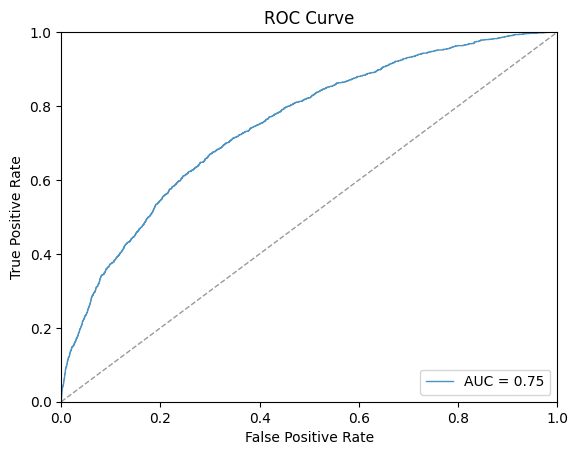

In [82]:
# FastText Standard Example
import fasttext
from sklearn.linear_model import LogisticRegression
from gensim.models import FastText
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

std_fasttext_data = full_dataframe

# prepare input file for fasttext
with open('fast_text_input.txt','w+') as file:
    for row in std_fasttext_data['ingredient']:
        row = [item.replace(' ','-') for item in row]
        file.write(' '.join(row) + '\n')

# train fasttext model using two different algorithms
standard_model = fasttext.train_unsupervised('./fast_text_input.txt')

# test basic similarity search results
print("Basic similarity search on sugar:")
print(standard_model.get_nearest_neighbors('sugar', 6))

# converts an ingredient string to a feature vector
def ingredient_to_vector(ingredient):
    return standard_model.get_word_vector(ingredient)

# Convert each ingredient in each recipe to a feature vector
std_fasttext_data['features'] = std_fasttext_data['ingredient'].apply(lambda x: [ingredient_to_vector(ingredient) for ingredient in x])

# Compute the mean feature vector for each recipe
std_fasttext_data['mean_vector'] = std_fasttext_data['features'].apply(lambda x: np.mean(x, axis=0))

# Split the data into training and test sets
train_data = std_fasttext_data.sample(frac=0.7, random_state=1)
test_data = std_fasttext_data.drop(train_data.index)

print('training logistic regression model')

# Train a logistic regression model on the mean feature vectors
USDA_log_regression_model = LogisticRegression(max_iter=2000)
USDA_log_regression_model.fit(train_data['mean_vector'].tolist(), train_data['USDAlabel'])

# Evaluate the model on the test data
USDA_accuracy = USDA_log_regression_model.score(test_data['mean_vector'].tolist(), test_data['USDAlabel'])
print(f"USDA label Accuracy: {USDA_accuracy}")

# Train a logistic regression model on the mean feature vectors
FSA_log_regression_model = LogisticRegression(max_iter=2000)
FSA_log_regression_model.fit(train_data['mean_vector'].tolist(), train_data['FSAlabel'])

# Evaluate the model on the test data
FSA_accuracy = FSA_log_regression_model.score(test_data['mean_vector'].tolist(), test_data['FSAlabel'])
print(f"FSA label Accuracy: {FSA_accuracy}")

# Predict probabilities
probas = FSA_log_regression_model.predict_proba(test_data['mean_vector'].tolist())
print(probas)

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(test_data['FSAlabel'], probas[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1, alpha=0.8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


Basic similarity search on sugar:
[('vanilla sugar', 0.7225114703178406), ('cinnamon sugar', 0.6999355554580688), ('white sugar', 0.6478004455566406), ("confectioners' sugar", 0.6327875256538391), ('vanilla bean past', 0.5985702872276306)]
training logistic regression model
USDA label Accuracy: 0.7731444130697862
FSA label Accuracy: 0.9233561920129084
[[0.8093309  0.1906691 ]
 [0.84353381 0.15646619]
 [0.83403368 0.16596632]
 ...
 [0.95179283 0.04820717]
 [0.98844046 0.01155954]
 [0.95673095 0.04326905]]


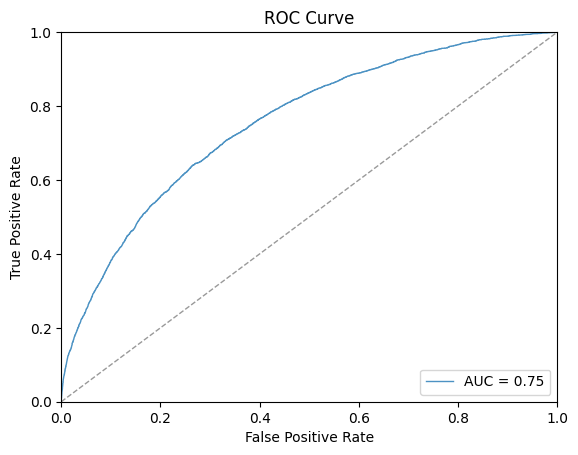

In [71]:
# FastText Gensim Example
from sklearn.linear_model import LogisticRegression
from gensim.models import FastText

gensim_fasttext_data = full_dataframe

gensim_model = FastText(gensim_fasttext_data['ingredient'], vector_size=100, window=5, min_count=1, sg=1, epochs=10)

print("Basic similarity search on sugar:")
print(gensim_model.wv.most_similar(positive=['sugar'], topn=5))

# Compute the mean values for each recipe
gensim_fasttext_data['mean_value'] = gensim_fasttext_data['ingredient'].apply(lambda x: np.mean([gensim_model.wv[word] for word in x if word in gensim_model.wv], axis=0))

# Split the data into training and test sets
train_data = gensim_fasttext_data.sample(frac=0.7, random_state=1)
test_data = gensim_fasttext_data.drop(train_data.index)

print('training logistic regression model')

# Train a logistic regression model on the mean feature vectors
USDA_log_regression_model = LogisticRegression(max_iter=2000)
USDA_log_regression_model.fit(train_data['mean_vector'].tolist(), train_data['USDAlabel'])

# Evaluate the model on the test data
USDA_accuracy = USDA_log_regression_model.score(test_data['mean_vector'].tolist(), test_data['USDAlabel'])
print(f"USDA label Accuracy: {USDA_accuracy}")

# Train a logistic regression model on the mean feature vectors
FSA_log_regression_model = LogisticRegression(max_iter=2000)
FSA_log_regression_model.fit(train_data['mean_vector'].tolist(), train_data['FSAlabel'])

# Evaluate the model on the test data
FSA_accuracy = FSA_log_regression_model.score(test_data['mean_vector'].tolist(), test_data['FSAlabel'])
print(f"FSA label Accuracy: {FSA_accuracy}")

# Predict probabilities
probas = FSA_log_regression_model.predict_proba(test_data['mean_vector'].tolist())
print(probas)

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(test_data['FSAlabel'], probas[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1, alpha=0.8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()